Importing Libraries

In [2]:
!pip install -q kaggle
!pip install -U spacy
#first install the library that would help us use BERT in an easy to use interface
#https://github.com/UKPLab/sentence-transformers/tree/master/sentence_transformers
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.9 MB/s 
     |████████████████████████████████| 5.8 MB 26.5 MB/s 
     |████████████████████████████████| 1.3 MB 52.7 MB/s 
     |████████████████████████████████| 182 kB 84.1 MB/s 
     |████████████████████████████████| 7.6 MB 59.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=f20fbe23bfca8f8d6660e0148be66b4ed6a3819818ae3774acf9ba111ca335ca
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [38]:
import pandas as pd
import re
from tqdm import tqdm

import gensim
from gensim.summarization import summarize

from sentence_transformers import SentenceTransformer, util
import scipy.spatial
import pickle as pkl
import torch
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Data

In [10]:
!mkdir ~/.kaggle/
!cp /content/drive/MyDrive/MABA-6490/Assignment1/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [11]:
!kaggle datasets download -d hamzafarooq50/hotel-listings-and-reviews

 59% 5.00M/8.54M [00:00<00:00, 42.1MB/s]
100% 8.54M/8.54M [00:00<00:00, 65.3MB/s]


In [12]:
!ls
!unzip hotel-listings-and-reviews.zip -d hotel-listings-and-reviews/

drive  hotel-listings-and-reviews.zip  sample_data
Archive:  hotel-listings-and-reviews.zip
  inflating: hotel-listings-and-reviews/HotelListInAthens__en2019100120191005.csv  
  inflating: hotel-listings-and-reviews/HotelListInAustin__en2019100120191005.csv  
  inflating: hotel-listings-and-reviews/HotelListInBali__en2019100120191005.csv  
  inflating: hotel-listings-and-reviews/HotelListInBangkok__en2019100120191005.csv  
  inflating: hotel-listings-and-reviews/HotelListInBarcelona__en2019100120191005.csv  
  inflating: hotel-listings-and-reviews/HotelListInBombay__en2019100120191005.csv  
  inflating: hotel-listings-and-reviews/HotelListInChicago__en2019100120191005.csv  
  inflating: hotel-listings-and-reviews/HotelListInDubai__en2019100120191005.csv  
  inflating: hotel-listings-and-reviews/HotelListInHong Kong__en2019100120191005.csv  
  inflating: hotel-listings-and-reviews/HotelListInIstanbul__en2019100120191005.csv  
  inflating: hotel-listings-and-reviews/HotelListInLondon__en

In [49]:
df = pd.read_csv("hotel-listings-and-reviews/hotelReviewsInPhuket__en2019100120191005.csv",dtype="str")

In [50]:
df.head()

,Unnamed: 0,review_body,review_date,hotelName,hotelUrl
0,0,Splash Beach Resort is well located and has ev...,"July 11, 2019",0 Splash Beach Resort by Langham Hospitalit...,http://www.tripadvisor.com/Hotel_Review-g12236...
1,1,We have been staying at the splash beach resor...,"July 8, 2019",0 Splash Beach Resort by Langham Hospitalit...,http://www.tripadvisor.com/Hotel_Review-g12236...
2,2,Hotel was really nice and clean. The lady who ...,"July 6, 2019",0 Splash Beach Resort by Langham Hospitalit...,http://www.tripadvisor.com/Hotel_Review-g12236...
3,3,It was plesure to stay for 4th time in Splash....,"July 4, 2019",0 Splash Beach Resort by Langham Hospitalit...,http://www.tripadvisor.com/Hotel_Review-g12236...
4,4,I stayed here for 2 nights. This was the perfe...,"July 4, 2019",0 Splash Beach Resort by Langham Hospitalit...,http://www.tripadvisor.com/Hotel_Review-g12236...


#Data Preprocessing

Applying regex expressions to extract the names of the hotels.

In [51]:
string_pattern = r"(?<=    )(.*)"
# compile string pattern to re.Pattern object
regex_pattern = re.compile(string_pattern)

def get_content(string):
  try:
    output = str(regex_pattern.findall(string)[0])
  except:
    output =  string
  return output

In [52]:
df['hotelName'] = [get_content(name) for name in df['hotelName']]

In [53]:
df['hotelName'].value_counts()

The Yama Hotel Phuket                                90
Pullman Phuket Panwa Beach Resort                    90
Splash Beach Resort by Langham Hospitality Group     54
Sunset Beach Resort                                  54
The Old Phuket                                       54
The Mangrove Panwa Phuket Resort                     54
Deevana Patong Resort & Spa                          54
Orchidacea Resort - Kata Beach, Phuket               54
Friendship Beach Resort & Atmanjai Wellness Ce...    54
Holiday Inn Resort Phuket Mai Khao Beach             54
Serenity Resort & Residences Phuket                  54
Thavorn Beach Village Resort & Spa                   54
Horizon Karon Beach Resort & Spa                     54
Centara Karon Resort Phuket                          54
Alpina Phuket Nalina Resort & Spa                    54
Cocoville Phuket                                     54
Bandara Phuket Beach Resort                          54
Phuket Orchid Resort & Spa                      

Dropping the duplicates

In [54]:
df['hotelName'].drop_duplicates()

0        Splash Beach Resort by Langham Hospitality Group
54                            Bandara Phuket Beach Resort
108                             Palm Garden Resort Phuket
162                                      Cape Panwa Hotel
216                                           Casa Blanca
270                                 The Yama Hotel Phuket
360                                 Novotel Phuket Resort
414                       Crowne Plaza Phuket Panwa Beach
468                                  Naiharn Beach Resort
522               The Village Coconut Island Beach Resort
576                                      Garden Home Kata
629                                   Beyond Resort Karon
683                               Phu NaNa Boutique Hotel
737                     Novotel Phuket Surin Beach Resort
791                            Phuket Orchid Resort & Spa
845                                      Cocoville Phuket
899                                   Sunset Beach Resort
953           

In [55]:
df.head()

,Unnamed: 0,review_body,review_date,hotelName,hotelUrl
0,0,Splash Beach Resort is well located and has ev...,"July 11, 2019",Splash Beach Resort by Langham Hospitality Group,http://www.tripadvisor.com/Hotel_Review-g12236...
1,1,We have been staying at the splash beach resor...,"July 8, 2019",Splash Beach Resort by Langham Hospitality Group,http://www.tripadvisor.com/Hotel_Review-g12236...
2,2,Hotel was really nice and clean. The lady who ...,"July 6, 2019",Splash Beach Resort by Langham Hospitality Group,http://www.tripadvisor.com/Hotel_Review-g12236...
3,3,It was plesure to stay for 4th time in Splash....,"July 4, 2019",Splash Beach Resort by Langham Hospitality Group,http://www.tripadvisor.com/Hotel_Review-g12236...
4,4,I stayed here for 2 nights. This was the perfe...,"July 4, 2019",Splash Beach Resort by Langham Hospitality Group,http://www.tripadvisor.com/Hotel_Review-g12236...


Grouping the reviews hotel-wise.

In [56]:
df_combined = df.sort_values(['hotelName']).groupby('hotelName', sort=False).review_body.apply(''.join).reset_index(name='all_review')

def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

df_combined['all_review']= df_combined['all_review'].apply(lambda x: x.lower())

df = df_combined

Summarizing the reviews using gensim summarizer.

In [57]:
def summarize_review(string):
  try:
    return summarize(string, ratio=0.005)
  except:
    return string

In [58]:
df['sum_review'] = [summarize_review(summary) for summary in df['all_review']]

Removing special characters, emojis etc from the reviews and building the corpus.

In [59]:
df['all_review'] = df['all_review'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

In [60]:
df_sentences = df_combined.set_index("hotelName")
df_sentences = df_sentences["all_review"].to_dict()
df_sentences_list = list(df_sentences.values())
corpus = [str(d) for d in tqdm(df_sentences_list)]

100%|██████████| 30/30 [00:00<00:00, 59521.82it/s]


#Modelling - Sentence Transformer model for Semantic Search

In [74]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [75]:
query = input("Search here:")

Search here:bad


In [76]:
corpus_embeddings = model.encode(corpus)
query_embeddings = model.encode(query, convert_to_tensor=True)





Query: bad

Top 5 most similar sentences in corpus:

having had a 15 hr flight we were extremely gr... (Score: 0.1291)
Hotel:   Horizon Karon Beach Resort & Spa 

we came all the way from new zealand so ws nic... (Score: 0.1258)
Hotel:   The Village Coconut Island Beach Resort 

 (Score: 0.1124)
Hotel:   Novotel Phuket Resort 

top staff, top rooms, but breakfast not very p... (Score: 0.1065)
Hotel:   The Old Phuket 

the staff here were very kind.- each day there... (Score: 0.0871)
Hotel:   Novotel Phuket Surin Beach Resort 



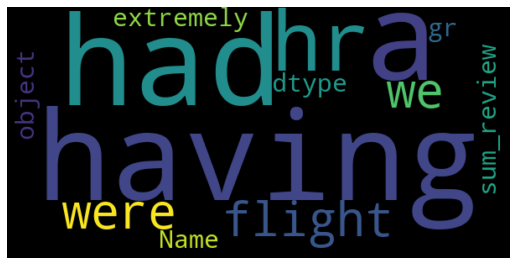

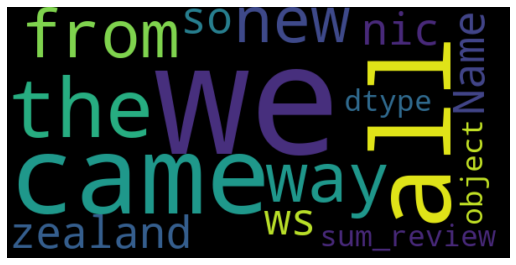

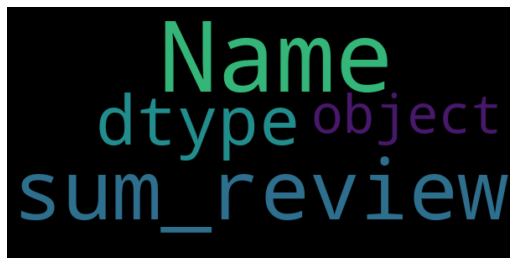

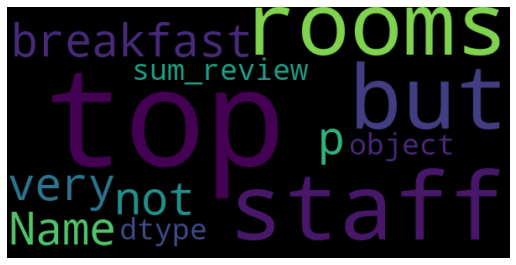

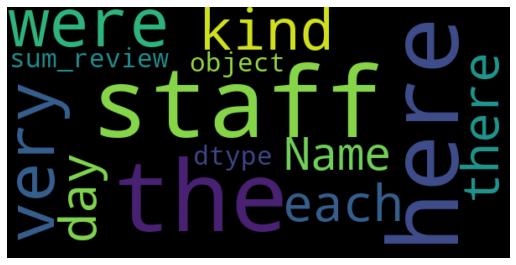

In [79]:
top_k = min(5, len(corpus))
cos_scores = util.pytorch_cos_sim(query_embeddings, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)
wordcloud = WordCloud(random_state = 8,
        normalize_plurals = False,
        width = 600, height= 300,
        max_words = 300,
        stopwords = [])
print("\n\n======================\n\n")
print("Query:", query)
print("\nTop 5 most similar sentences in corpus:\n")

for score, idx in zip(top_results[0], top_results[1]):
  row_dict = df.loc[df['all_review']== corpus[idx]]
  print(get_content(str(row_dict['sum_review'])), "(Score: {:.4f})".format(score))
  print("Hotel:  " , get_content(str(row_dict['hotelName'])), "\n")

  wordcloud.generate(str(row_dict['sum_review']))
  # create a figure
  fig, ax = plt.subplots(1,1, figsize = (9,6))
  # add interpolation = bilinear to smooth things out
  plt.imshow(wordcloud, interpolation='bilinear')
  # and remove the axis
  plt.axis("off")

  

#Exporting as pickle files

Exporting df, corpus, corpus embeddings and model as pickle files to import into streamlit app.

In [80]:
with open("df.pkl" , "wb") as file_:
 pkl.dump(df,file_)

with open("corpus.pkl" , "wb") as file_:
 pkl.dump(corpus,file_)

with open("corpus_embeddings.pkl" , "wb") as file_:
 pkl.dump(corpus_embeddings,file_)

with open("model.pkl" , "wb") as file_:
 pkl.dump(model,file_)

In [81]:
# !pip freeze > requirement.txt

In [82]:
# model = SentenceTransformer('sentence-transformers/paraphrase-xlm-r-multilingual-v1')
# corpus_embeddings = model.encode(corpus)
# query = input("Search here:")
# query_embedding = model.encode(query, convert_to_tensor=True)
# # top_k = int(input("maximum results to be displayed:"))
# hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=int(input("Maximum results to be displayed:")))
# hits = hits[0]      #Get the hits for the first query

# for hit in hits:
#   row_dict = df.loc[df['all_review']== corpus[hit['corpus_id']]]
#   print(get_content(str(row_dict['sum_review'])))
#   print("Hotel:  ", get_content(str(row_dict['hotelName'])), "\n")